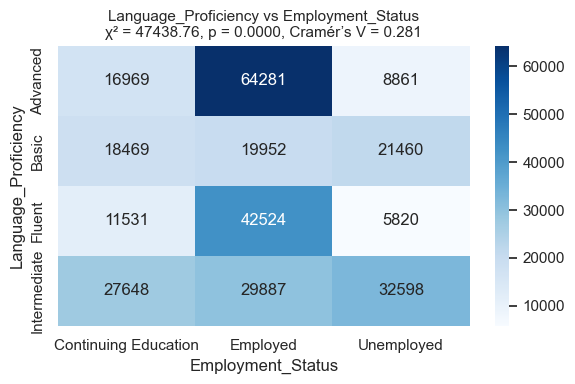

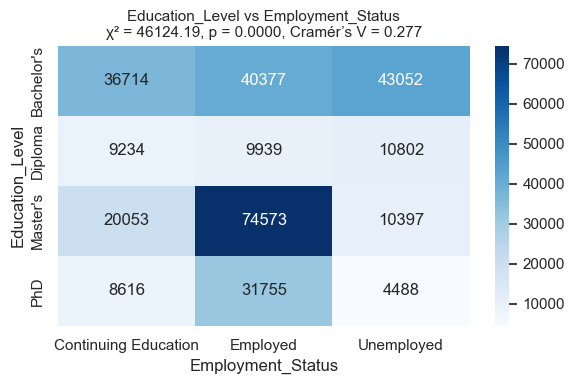

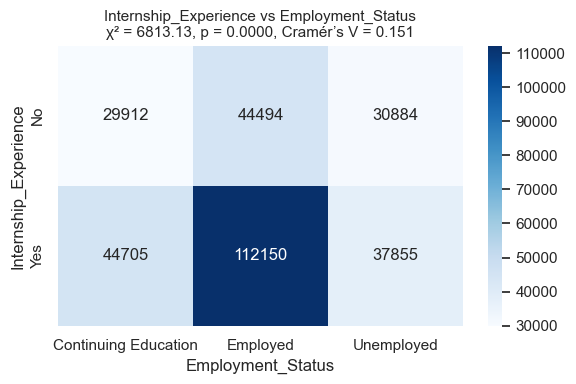

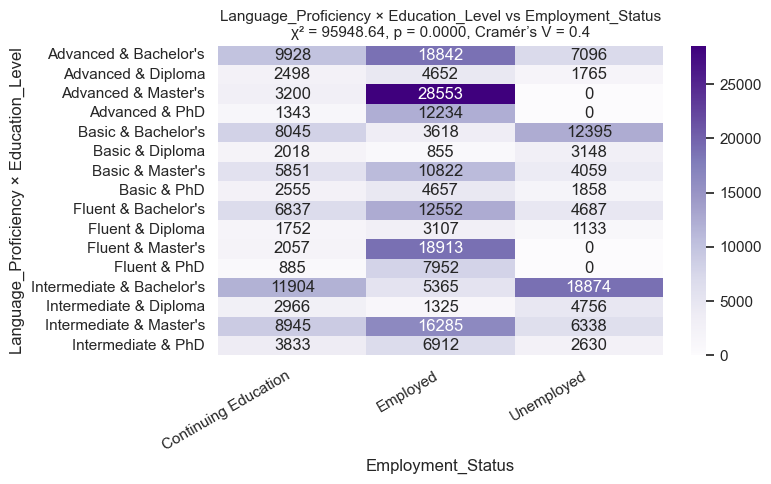

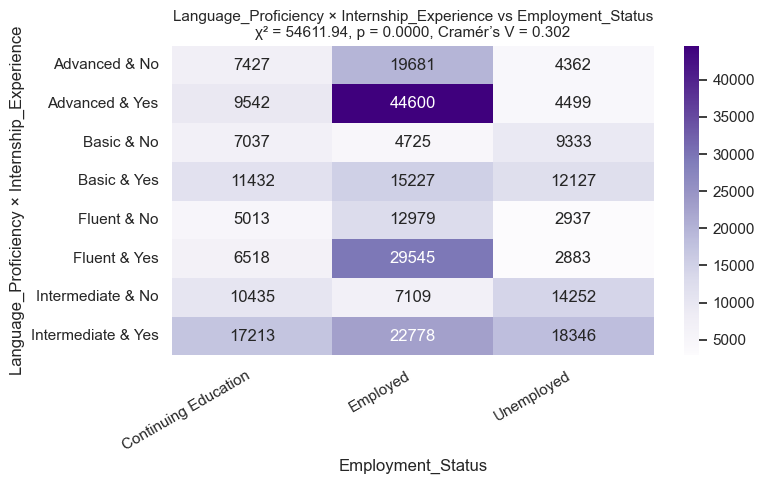

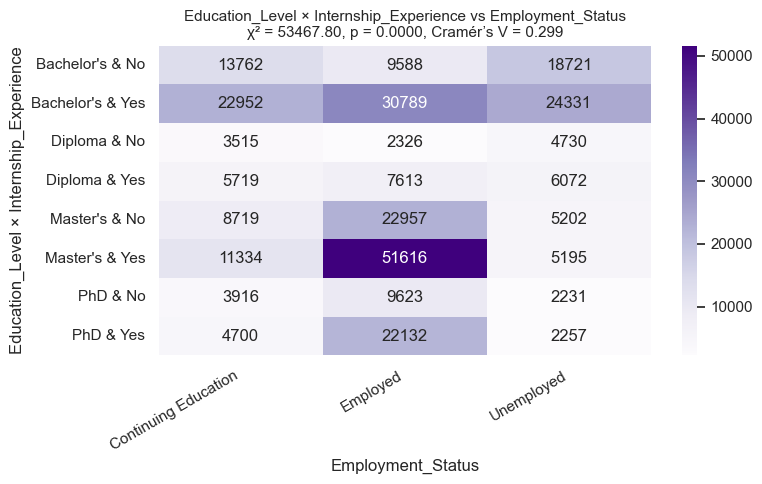

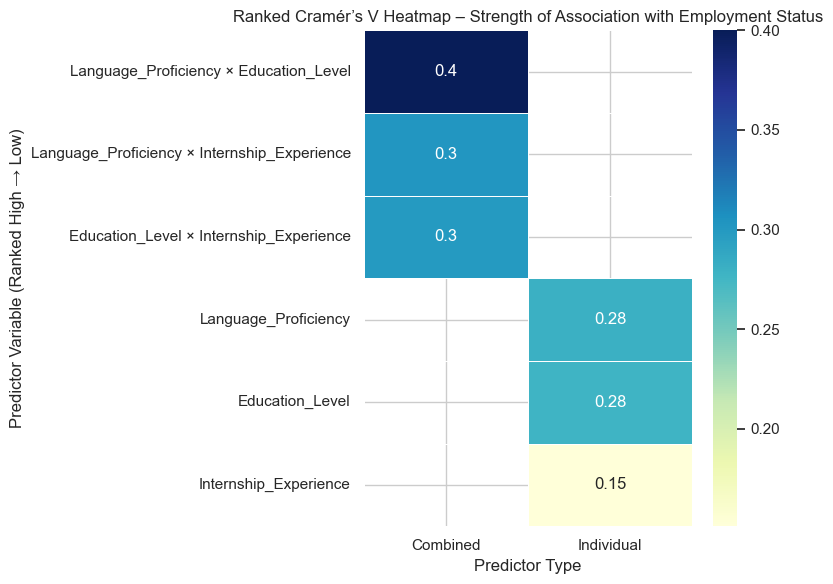

✅ All contingency tables exported to:
   → Contingency_Tables.xlsx (Excel summary)
   → contingency_tables_png/ folder (PNG plots with χ², p, and Cramér’s V)


In [ ]:
# ============================================================
# 🎓 Export Contingency Tables and Ranked Heatmap to Excel + PNG Images
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import os

# === 1. Load Dataset ===
df = pd.read_csv("cleaned_dataset.csv")

# Select relevant columns
cols = ['Language_Proficiency', 'Education_Level', 'Internship_Experience', 'Employment_Status']
df = df[cols].dropna()

# Convert to categorical strings
for c in cols:
    df[c] = df[c].astype(str)

# === 2. Helper function for Cramér’s V ===
def cramers_v(conf_matrix):
    chi2 = chi2_contingency(conf_matrix)[0]
    n = conf_matrix.sum().sum()
    r, k = conf_matrix.shape
    return round((chi2 / (n * (min(k - 1, r - 1)))) ** 0.5, 3)

# === 3. Prepare output folders ===
os.makedirs("contingency_tables_png", exist_ok=True)

# === 4. Generate contingency tables ===
predictors = ['Language_Proficiency', 'Education_Level', 'Internship_Experience']
outcome = 'Employment_Status'
combined_pairs = [
    ('Language_Proficiency', 'Education_Level'),
    ('Language_Proficiency', 'Internship_Experience'),
    ('Education_Level', 'Internship_Experience')
]

writer = pd.ExcelWriter("Contingency_Tables.xlsx", engine='xlsxwriter')

# --- Individual Predictors ---
summary_list = []

for predictor in predictors:
    table = pd.crosstab(df[predictor], df[outcome], margins=True)
    chi2, p, dof, expected = chi2_contingency(table.iloc[:-1, :-1])
    v = cramers_v(table.iloc[:-1, :-1])

    summary_list.append([predictor, "Individual", chi2, dof, p, v])

    # Write table to Excel
    table.to_excel(writer, sheet_name=predictor[:31])

    # Create PNG heatmap with χ², p, V
    plt.figure(figsize=(6, 4))
    sns.heatmap(table.iloc[:-1, :-1], annot=True, cmap="Blues", fmt="d")
    plt.title(
        f"{predictor} vs {outcome}\n"
        f"χ² = {chi2:.2f}, p = {p:.4f}, Cramér’s V = {v}",
        fontsize=11
    )
    plt.tight_layout()
    plt.savefig(f"contingency_tables_png/{predictor}_vs_{outcome}.png", dpi=300)
    plt.show()
    plt.close()

# --- Combined Predictors ---
for pair in combined_pairs:
    combo_col = f"{pair[0]} × {pair[1]}"
    df[combo_col] = df[pair[0]] + " & " + df[pair[1]]

    table = pd.crosstab(df[combo_col], df[outcome], margins=True)
    chi2, p, dof, expected = chi2_contingency(table.iloc[:-1, :-1])
    v = cramers_v(table.iloc[:-1, :-1])

    summary_list.append([combo_col, "Combined", chi2, dof, p, v])

    # Write to Excel
    table.to_excel(writer, sheet_name=combo_col[:31])

    # Create PNG heatmap with χ², p, V
    plt.figure(figsize=(8, 5))
    sns.heatmap(table.iloc[:-1, :-1], annot=True, cmap="Purples", fmt="d")
    plt.title(
        f"{combo_col} vs {outcome}\n"
        f"χ² = {chi2:.2f}, p = {p:.4f}, Cramér’s V = {v}",
        fontsize=11
    )
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.savefig(f"contingency_tables_png/{combo_col}_vs_{outcome}.png", dpi=300)
    plt.show()
    plt.close()

# --- Summary Sheet ---
summary_df = pd.DataFrame(
    summary_list, columns=["Predictor", "Type", "Chi2", "df", "p-value", "Cramér’s V"]
)
summary_df = summary_df.sort_values("Cramér’s V", ascending=False)
summary_df.to_excel(writer, sheet_name="Summary", index=False)
writer.close()

# === 5. Ranked Heatmap (Highest → Lowest Association) ===
sns.set(style="whitegrid")
heat_data = summary_df.pivot(index='Predictor', columns='Type', values='Cramér’s V')
heat_data = heat_data.loc[summary_df['Predictor'].unique()]

plt.figure(figsize=(8, 6))
sns.heatmap(heat_data, annot=True, cmap="YlGnBu", linewidths=0.5)
plt.title("Ranked Cramér’s V Heatmap – Strength of Association with Employment Status")
plt.xlabel("Predictor Type")
plt.ylabel("Predictor Variable (Ranked High → Low)")
plt.tight_layout()
plt.savefig("contingency_tables_png/Ranked Cramér’s V Heatmap.png", dpi=300)
plt.show()
plt.close()

print("✅ All contingency tables exported to:")
print("   → Contingency_Tables.xlsx (Excel summary)")
print("   → contingency_tables_png/ folder (PNG plots with χ², p, and Cramér’s V)")
